In [114]:
# Import packages
import argparse, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from STMiner.SPFinder import SPFinder
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from tqdm import tqdm
from scipy import sparse
# from anndata import read_h5ad

In [3]:
EPS_CUTOFF = 1e-10  # treat values ≤ this as zero (sentinels introduced in script 3)

In [116]:
# Define helper functions

#------------------------------------------------------------------------------#
# Non exported helpers from STMiner
#------------------------------------------------------------------------------#
def get_exp_array(adata, gene_name, remove_low_exp_spots=False):
    sparse_matrix = _preprocess(adata, gene_name)
    return _to_dense(remove_low_exp_spots, sparse_matrix)

def _to_dense(remove_low_exp_spots, sparse_matrix):
    if sparse_matrix is not None:
        dense_array = sparse_matrix.todense()
        if remove_low_exp_spots:
            dense_array = np.maximum(dense_array - np.mean(dense_array[dense_array != 0]), 0)
        return _round(dense_array)
    else:
        print("matrix is None")
        
def _round(array):
    return np.array(np.round(array), dtype=np.int16)

def _preprocess(adata, gene_name):
    if gene_name not in adata.var_names:
        print(f"Warning: {gene_name} is not in adata gene list.")
    else:
        exp_array = adata[:, adata.var_names == gene_name].X
        if sparse.issparse(exp_array):
            data = np.array(exp_array.todense())
        else:
            data = np.array(exp_array)
        sparse_matrix = sparse.coo_matrix((data[:, 0], (np.array(adata.obs['x']), np.array(adata.obs['y']))), dtype=np.int16)
        return sparse_matrix
    
#------------------------------------------------------------------------------#
# Custom helpers
#------------------------------------------------------------------------------#
def morans_I(score, indices):
    # k-NN row-normalised weights
    n = score.size
    x = score - score.mean()
    # build W implicit via indices
    S0 = 0.0
    num = 0.0
    for i in range(n):
        neigh = indices[i]
        if len(neigh)==0: 
            continue
        w = 1.0 / len(neigh)
        S0 += len(neigh) * w
        num += np.sum(w * (x[i]) * x[neigh])
    den = np.sum(x * x)
    return (n / S0) * (num / den) if den > 0 and S0 > 0 else np.nan

def boundary_mask(labels, indices):
    lab = labels.to_numpy()
    # boundary if any neighbour has different label
    diffs = (lab[indices] != lab[:, None])
    return diffs.any(1)



In [ ]:
def build_pattern_vote_proportions(sp, adata, vote_rate=0.05):
    """
    Reconstruct per-spot vote COUNTS and PROPORTIONS for each STMiner pattern.

    For each pattern label:
      - For each gene in the pattern, find non-zero pixels in its exp raster (as STMiner does).
      - Count how many genes hit each pixel -> vote counts.
      - Apply vote threshold: keep only pixels where count / n_genes >= vote_rate.
      - Map pixel (row,col) -> spot index using sp.adata.obs['x'],['y'].
      - For each spot, write:
          pattern_<lab>_count  = votes at this spot  (integer in [0, n_genes])
          pattern_<lab>_prop   = votes / n_genes     (float in [0,1])

    This avoids using 'total_count' intensities, which are not counts -> (my 
    initial approach that produced nonsense results).
    """
    # Ensure adata rows match sp.adata
    if not np.array_equal(adata.obs_names.astype(str), sp.adata.obs_names.astype(str)):
        adata = adata[sp.adata.obs_names.astype(str)].copy()

    # Map grid coordinates -> spot row index once
    row_idx = sp.adata.obs["x"].astype(int).to_numpy()
    col_idx = sp.adata.obs["y"].astype(int).to_numpy()
    coord_to_spot = {(int(r), int(c)): int(i) for i, (r, c) in enumerate(zip(row_idx, col_idx))}

    # Pattern labels and gene sets
    gl = pd.DataFrame(sp.genes_labels).copy()
    labcol = "labels" if "labels" in gl.columns else next(
        c for c in gl.columns if c.lower() in ("label", "cluster", "pattern"))
    gl[labcol] = gl[labcol].astype(str)
    label_list = sorted(gl[labcol].unique(), key=str)

    count_cols = {}
    prop_cols  = {}

    for lab in label_list:
        gene_list = list(gl.loc[gl[labcol] == lab, "gene_id"].astype(str).values)
        if len(gene_list) == 0:
            # create zeros if empty pattern
            count_cols[f"pattern_{lab}_count"] = np.zeros(adata.n_obs, dtype=np.int32)
            prop_cols [f"pattern_{lab}_prop"]  = np.zeros(adata.n_obs, dtype=np.float32)
            continue

        # 1) Collect all non-zero coordinates across genes (exactly as STMiner does)
        total_coo_list = []
        for gene in tqdm(gene_list, desc=f"[pattern {lab}] collecting coords", leave=False):
            exp_matrix = get_exp_array(sp.adata, gene)  # STMiner's helper returns a raster
            rr, cc = np.nonzero(exp_matrix)
            # NOTE: do NOT rotate/flip here; STMiner counts before any plot transforms
            total_coo_list.extend(zip(rr.astype(int), cc.astype(int)))

        # 2) Vote counts per (row,col)
        count_dict = Counter(total_coo_list)

        # 3) Apply vote rate threshold *per pixel*
        # keep only coords where fraction >= vote_rate
        keep = {coord: cnt for coord, cnt in count_dict.items()
                if (cnt / len(gene_list)) >= vote_rate}

        # 4) Map pixel coords to spot indices and build per-spot vectors
        counts_vec = np.zeros(adata.n_obs, dtype=np.int32)
        hits_mapped = 0
        for (r, c), cnt in keep.items():
            idx = coord_to_spot.get((int(r), int(c)))
            if idx is not None:
                counts_vec[idx] = cnt
                hits_mapped += 1
        if hits_mapped == 0:
            print(f"[pattern {lab}] WARNING: no kept pixels mapped to spots; check coord frames or vote_rate.")

        # 5) Proportions
        props = counts_vec.astype(np.float32) / float(len(gene_list))
        # numeric safety only; this should already be within [0,1]
        props = np.clip(props, 0.0, 1.0)

        count_cols[f"pattern_{lab}_count"] = counts_vec
        prop_cols [f"pattern_{lab}_prop"]  = props

    # Attach (overwrite) to adata.obs
    count_df = pd.DataFrame(count_cols, index=adata.obs_names)
    prop_df  = pd.DataFrame(prop_cols,  index=adata.obs_names)
    drop = count_df.columns.union(prop_df.columns)
    adata.obs.drop(columns=drop, errors="ignore", inplace=True)
    for df in (prop_df, count_df):
        for c in df.columns:
            adata.obs[c] = df[c].values

    # Sanity print
    pmin, pmax = float(prop_df.min().min()), float(prop_df.max().max())
    print(f"[votes] proportions in [{pmin:.3g}, {pmax:.3g}] with vote_rate={vote_rate} "
          f"(expected within [0,1])")

    return adata, count_df, prop_df


In [5]:
h5ad="/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/H1_5.h5ad"
fgwc_png="/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/fgwc_entropy.png"
out="/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/supp_overlap.png"
n_patterns=8
vote_rate=0.05
mds_components=10
min_cells=50
n_comp=10

In [ ]:
# Load sp and adata
sp = SPFinder()
sp.read_h5ad(file=h5ad, bin_size=1)
sp.adata.var_names = sp.adata.var['gene_name'].to_numpy()
adata = sp.adata
coords = adata.obsm["spatial"]
labels = adata.obs.get("label", None)
labels = labels.astype("category")

In [ ]:
# Get STMiner gene patterns
gene_cluster_path = "/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_gene_clusters.csv"
gene_lists = None
sp.get_genes_csr_array(min_cells=min_cells, log1p=False)
sp.spatial_high_variable_genes()
df = sp.global_distance
mask = df['z-score'].gt(0.5)
true_count = mask.sum()
print("Selected number of genes: ", true_count)
sp.fit_pattern(n_comp=n_comp, gene_list=list(sp.global_distance[:true_count]['Gene']), normalize=False)
sp.build_distance_array()
sp.cluster_gene(n_clusters=n_patterns, mds_components=mds_components)


Computing ot distances...: 100%|██████████| 2458/2458 [20:43<00:00,  1.98it/s]


Selected number of genes:  772


Fitting GMM...: 100%|██████████| 772/772 [04:31<00:00,  2.84it/s]


Number of dropped genes: 2


Building distance array...: 100%|██████████| 770/770 [02:58<00:00,  4.31it/s]


In [ ]:
gc = sp.genes_labels
gc.to_csv(gene_cluster_path)
gene_lists = [gc.index[gc["labels"] == k].tolist() for k in sorted(gc["labels"].unique())]

# Build the raster-based arrays first
sp.get_pattern_array(vote_rate=vote_rate, mode="vote")


Accumulating gene expression...: 100%|██████████| 88/88 [01:05<00:00,  1.35it/s]


In [117]:
adata, counts_df, prop_df = build_pattern_vote_proportions(sp, adata, vote_rate=0.05)

[votes] proportions in [0, 0.537] with vote_rate=0.05 (expected within [0,1])


In [9]:
# Neighbour graph and boundary mask
nbrs = NearestNeighbors(n_neighbors=6).fit(coords)
idx = nbrs.kneighbors(return_distance=False)
bmask = boundary_mask(labels, idx)

In [118]:
# Metrics per pattern
metrics = []
for i, _ in enumerate(gene_lists):
    s = adata.obs[f"pattern_{i}_prop"].to_numpy()
    # Area under the ROC curve (AUC) one-vs-rest for the most frequent label (or tumour if present)
    # summarises how well a continuous score separates one class from another: 0.5 ≈ chance, 1.0 = perfect
    levs = list(labels.cat.categories)
    if "GG4 Cribriform" in [l.lower() for l in levs]:
        lev = levs[[l.lower() for l in levs].index("GG4 Cribriform")]
    else:
        lev = labels.value_counts().idxmax()
    y = (labels == lev).astype(int).to_numpy()
    if (y.sum() == 0) or (y.sum() == len(y)):
        auc = np.nan
    else:
        try:
            auc = roc_auc_score(y, s)
        except Exception:
            auc = np.nan

    # Boundary localisation score (BLS - share of score mass on boundary)
    # Fraction of total uncertainty (entropy) concentrated on boundary spots (where neighbouring labels differ)
    # Higher = uncertainty is focused at interfaces
    s_pos = s - s.min()  # non-negative
    BLS = float(s_pos[bmask].sum() / (s_pos.sum() + 1e-12))

    # Boundary contrast index (BCI): mean |Δscore| on edges (all vs boundary edges)
    # Mean jump in class probability across neighbouring spots 
    # slide-wide (BCI_all), restricted to boundary edges (BCI_boundary)
    # Higher = sharper transitions at interfaces.
    diffs = np.abs(s[idx] - s[:, None])
    BCI_all = float(np.mean(diffs))
    BCI_boundary = float(np.mean(diffs[bmask]))

    # Moran's I of score
    I = morans_I(s, idx)

    metrics.append(dict(pattern=i, AUC=auc, BLS=BLS, BCI_all=BCI_all,
                        BCI_boundary=BCI_boundary, MoransI=I))
met = pd.DataFrame(metrics)
met.to_csv("/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_pattern_metrics.csv", index=False)


In [119]:
# Pick two patterns to plot (best boundary-localised & best AUC)
p1 = int(met.sort_values("BLS", ascending=False).iloc[0]["pattern"])
p2 = int(met.sort_values("AUC", ascending=False).iloc[0]["pattern"])
if p1 == p2 and len(met) > 1:
    p2 = int(met.sort_values("AUC", ascending=False).iloc[1]["pattern"])


In [120]:
print(p1)
print(p2)

2
1


Saved figure: /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/supp_overlap.png
Pattern metrics -> /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_pattern_metrics.csv


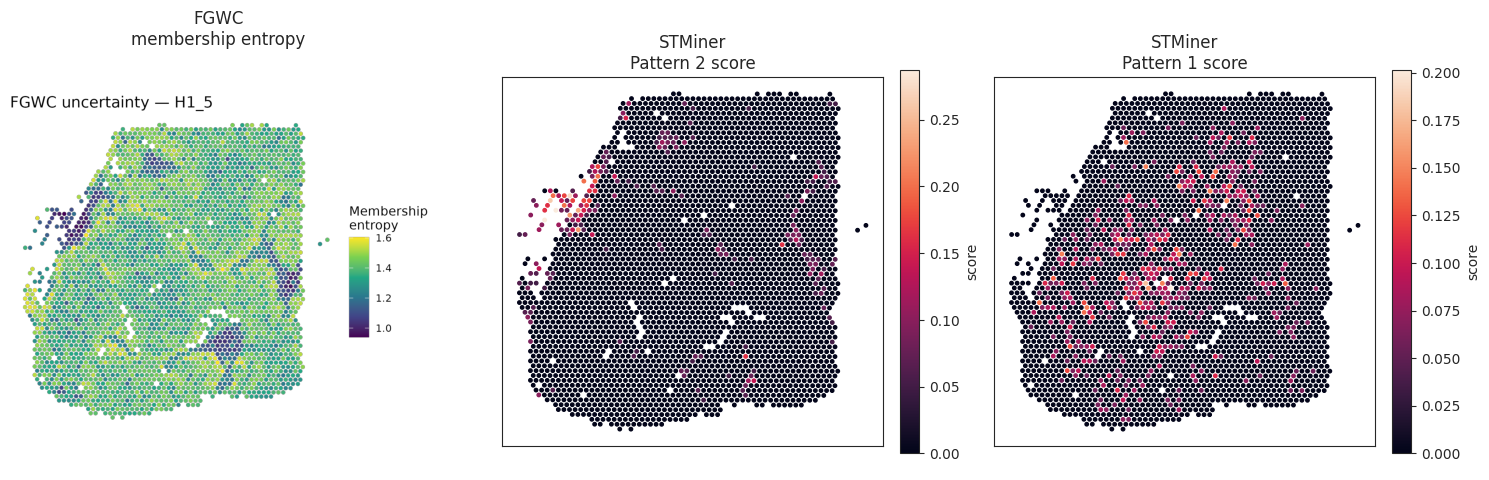

In [ ]:
# Make the composite figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Left: FGWC entropy (already saved by your R code)
img = plt.imread(fgwc_png)
axs[0].imshow(img)
axs[0].axis("off")
axs[0].set_title("FGWC\nmembership entropy")

# Middle & Right: STMiner pattern scores (two selected patterns)
for ax, pat in zip(axs[1:], [p1, p2]):
    sc = adata.obs[f"pattern_{pat}_prop"].to_numpy()
    im = ax.scatter(coords[:, 0], coords[:, 1], c=sc, s=6)
    # ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"STMiner\nPattern {pat} score")
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("score", rotation=90)

plt.tight_layout()
plt.savefig(out, dpi=300)
print(f"Saved figure: {out}")
print("Pattern metrics -> /mnt/c/Users/Lefteris/Downloads/STMiner_test/results/stminer_pattern_metrics.csv")


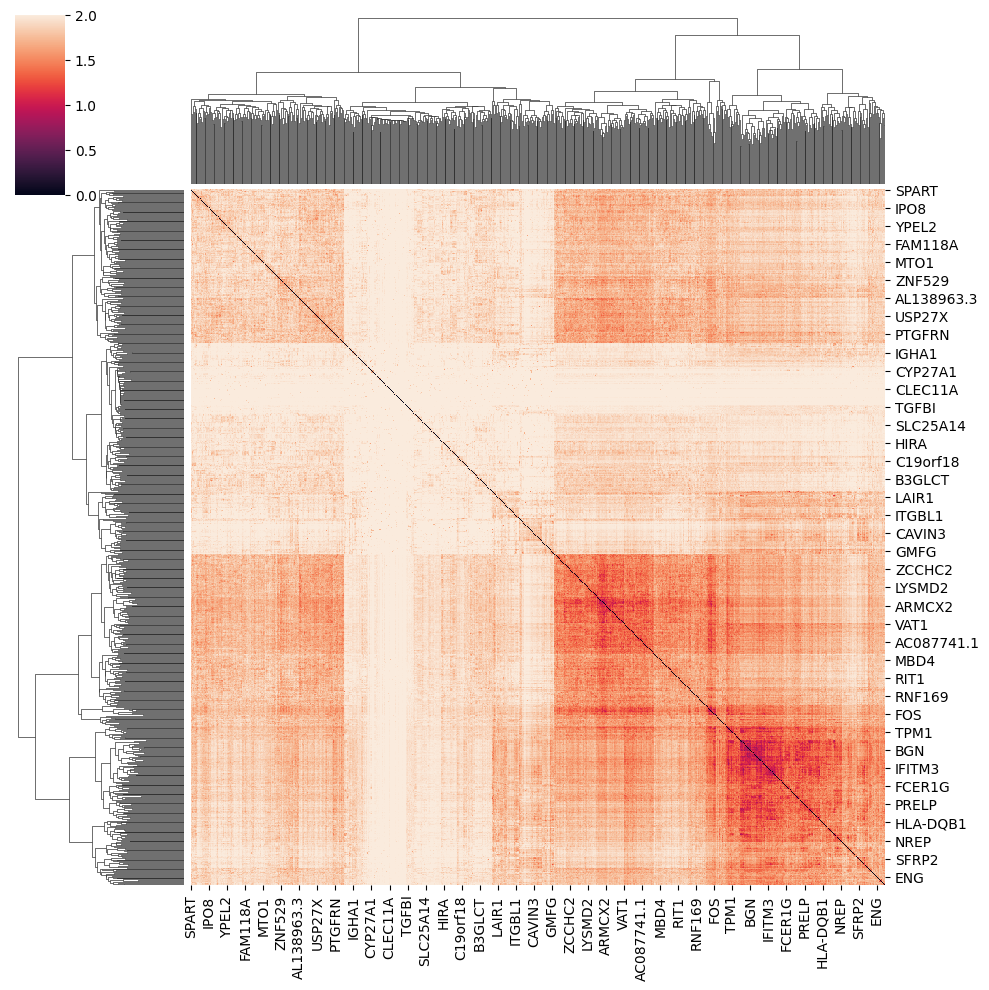

In [19]:
import seaborn as sns
sns.clustermap(sp.genes_distance_array)

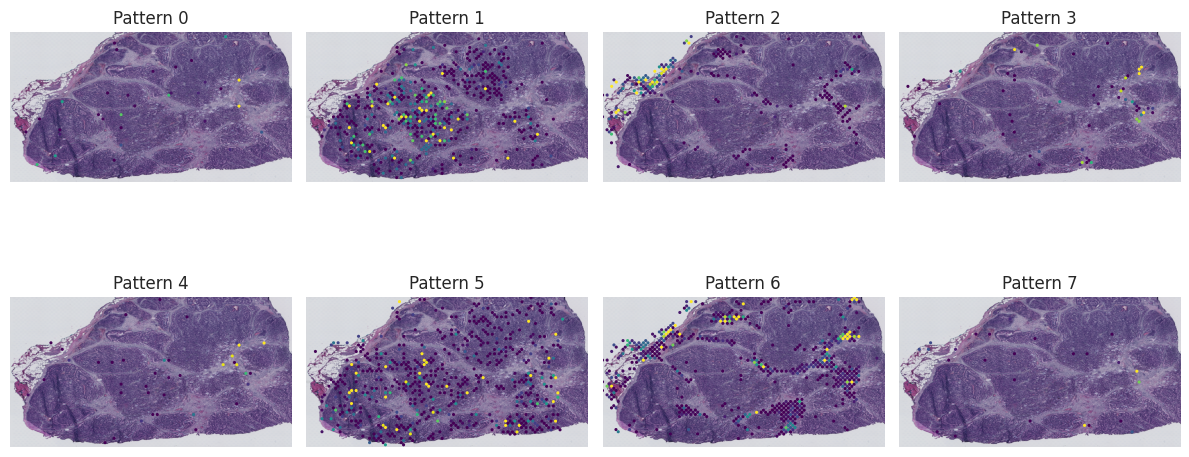

In [122]:
img2="/mnt/c/Users/Lefteris/Downloads/STMiner_test/data/H1_5/outs/spatial/tissue_lowres_image2.png"
outImg="/mnt/c/Users/Lefteris/Downloads/STMiner_test/results/pattern_plots/pattern_n8_vr0p05.png"
sp.plot.plot_pattern(
    heatmap=False,
    s=5,
    rotate=False,
    reverse_y=False,
    reverse_x=False,
    vmax=95,
    #cmap="Spectral_r",
    aspect=.55,
    image_path=img2,
    rotate_img=False,
    output_path=outImg
)

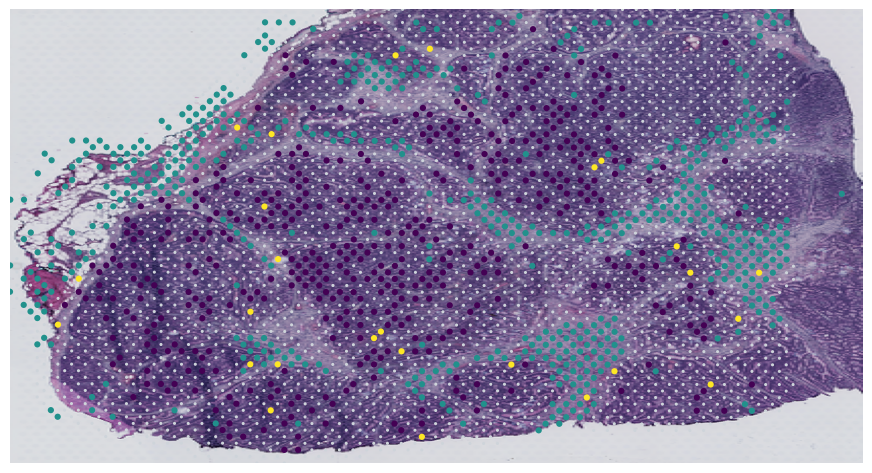

In [21]:
sp.plot.plot_intersection(pattern_list=[1, 6],
                          image_path=img2,
                          reverse_y=False,
                          reverse_x=False,
                          aspect=0.55,
                          figsize=(11,8),
                          s=20,
                          cmap="viridis",
)